## ARIMA Models
Notebook following along this article: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

### How to find the order of differencing `(d)` in ARIMA model

We can check if the series is stationary using the Augmented Dickey Fuller test (adfuller()), from the `statsmodels` package.

We need differencing only if the series is non-stationary. Else, no differencing is needed, that is, `d=0`.

The null hypothesis of the ADF test is that the time series is non-stationary. 
So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

In [1]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

In [2]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.464240
p-value: 0.124419


So, in our case, if P Value > 0.05 we go ahead with finding the order of differencing.

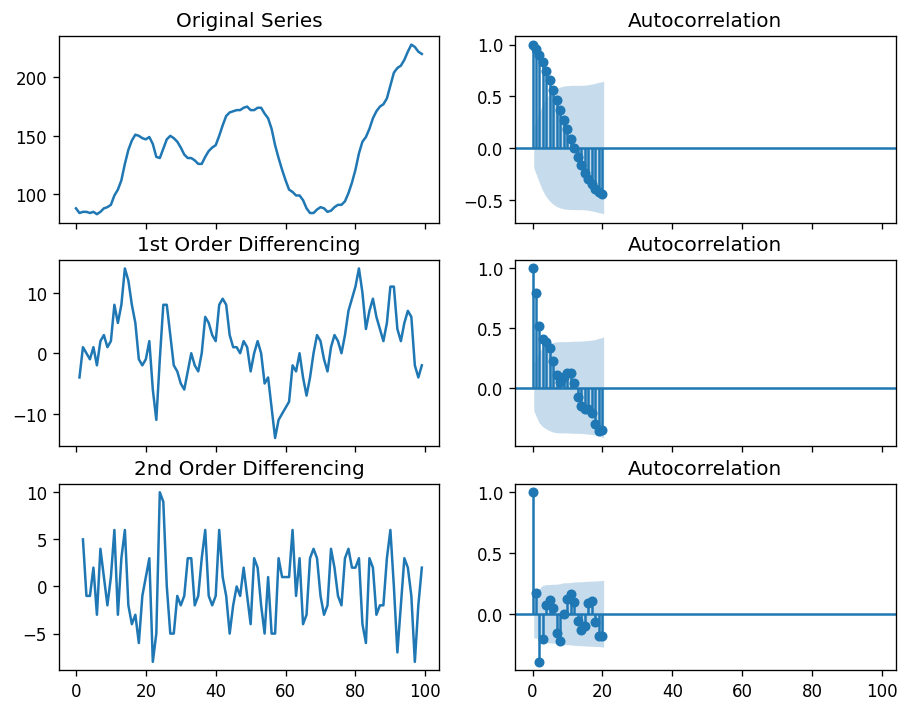

In [3]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.

So, I am going to tentatively fix the order of differencing as 1 even though the series is not perfectly stationary (weak stationarity).

In [4]:
from pmdarima.arima.utils import ndiffs
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
y = df.value

## Adf Test
ndiffs(y, test='adf')  # 2

# KPSS test
ndiffs(y, test='kpss')  # 0

# PP test:
ndiffs(y, test='pp')  # 2

2

### How to find the order of the AR term (p)

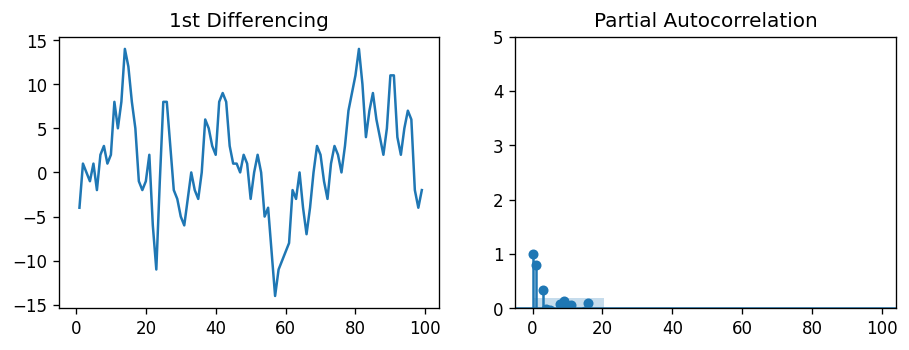

In [5]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()

### How to find the order of the MA term (q)

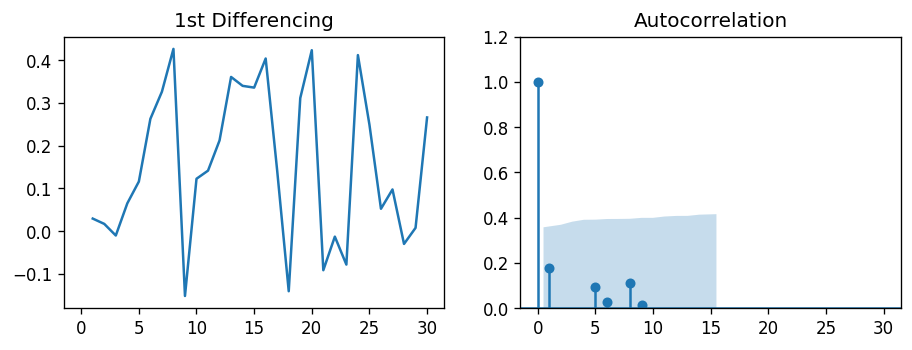

In [6]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Import data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/austa.csv')

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

###  How to handle if a time series is slightly under or over differenced

It may so happen that your series is slightly under differenced, that differencing it one more time makes it slightly over-differenced.

How to handle this case?

If your series is slightly under differenced, adding one or more additional AR terms usually makes it up. Likewise, if it is slightly over-differenced, try adding an additional MA term.

### How to build the ARIMA Model

In [8]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df.value, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   30
Model:                 ARIMA(1, 1, 2)   Log Likelihood                  11.512
Method:                       css-mle   S.D. of innovations              0.160
Date:                Wed, 18 Nov 2020   AIC                            -13.023
Time:                        09:10:57   BIC                             -6.017
Sample:                             1   HQIC                           -10.782
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1677      0.013     12.997      0.000       0.142       0.193
ar.L1.D.value     0.7104      0.177      4.013      0.000       0.363       1.057
ma.L1.D.value    -0.6119      0.217     

In [9]:
# 1,1,1 ARIMA Model
model = ARIMA(df.value, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   30
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  10.322
Method:                       css-mle   S.D. of innovations              0.171
Date:                Wed, 18 Nov 2020   AIC                            -12.645
Time:                        09:11:48   BIC                             -7.040
Sample:                             1   HQIC                           -10.852
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1540      0.037      4.158      0.000       0.081       0.227
ar.L1.D.value    -0.2906      0.481     -0.604      0.546      -1.233       0.652
ma.L1.D.value     0.5350      0.414     

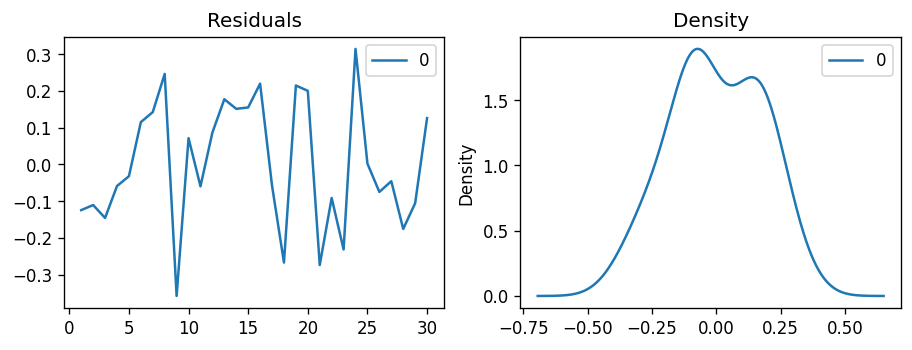

In [10]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

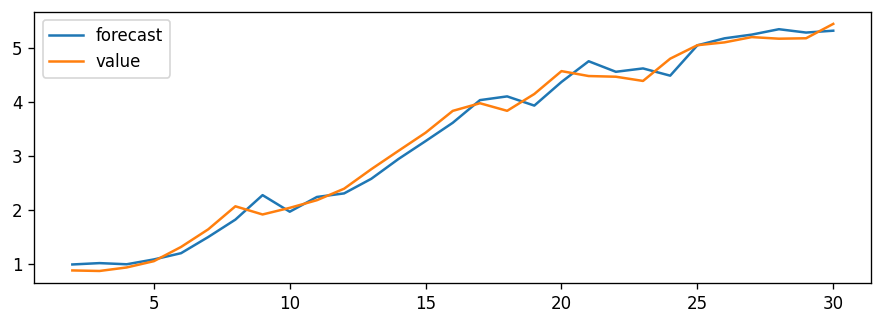

In [11]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

### How to do find the optimal ARIMA model manually using Out-of-Time Cross validation
In Out-of-Time cross-validation, you take few steps back in time and forecast into the future to as many steps you took back. Then you compare the forecast against the actuals.

To do out-of-time cross-validation, you need to create the training and testing dataset by splitting the time series into 2 contiguous parts in approximately 75:25 ratio or a reasonable proportion based on time frequency of series.

Why am I not sampling the training data randomly you ask?

That’s because the order sequence of the time series should be intact in order to use it for forecasting.

In [12]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df.value[:85]
test = df.value[85:]

You can now build the ARIMA model on training dataset, forecast and plot it.



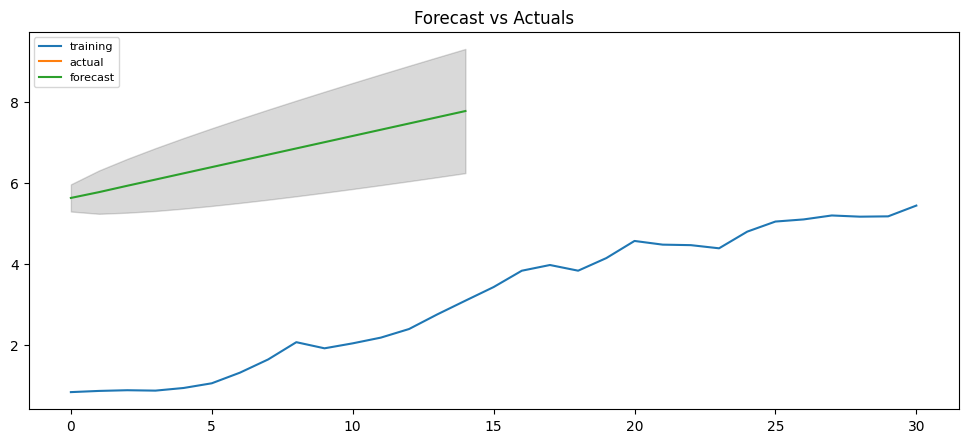

In [23]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc)
lower_series = pd.Series(conf[:, 0])
upper_series = pd.Series(conf[:, 1])

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()



                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   29
Model:                 ARIMA(3, 2, 1)   Log Likelihood                   8.277
Method:                       css-mle   S.D. of innovations              0.171
Date:                Wed, 18 Nov 2020   AIC                             -4.555
Time:                        09:17:35   BIC                              3.649
Sample:                             2   HQIC                            -1.985
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0004      0.004     -0.100      0.920      -0.007       0.007
ar.L1.D2.value     0.2302      0.191      1.206      0.228      -0.144       0.604
ar.L2.D2.value    -0.2096      0.184

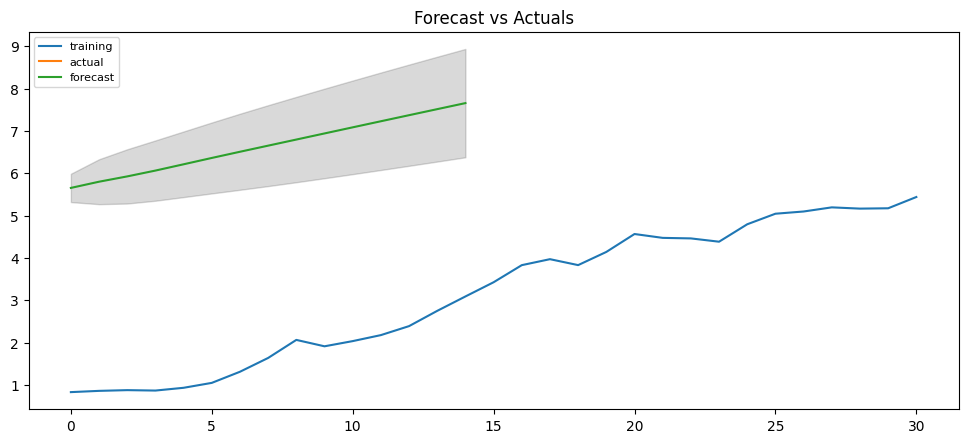

In [25]:
# Build Model
model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc)
lower_series = pd.Series(conf[:, 0])
upper_series = pd.Series(conf[:, 1])

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()